Sampling interval: 1.000 hours/sample
Top 5 dominant periods (with phase info):
-----------------------------------------------------------
1. Frequency = 1.0000 cycles/day, Amplitude = 67,578.93 (norm=1.0000), Period = 1.000 days (24.0 h), Phase = 3.084 rad, Peak at 50.9% of cycle (~12.2 h after start)
2. Frequency = 0.1429 cycles/day, Amplitude = 56,977.03 (norm=0.8431), Period = 7.000 days (168.0 h), Phase = -2.212 rad, Peak at 35.2% of cycle (~59.1 h after start)
3. Frequency = 1.0005 cycles/day, Amplitude = 33,210.36 (norm=0.4914), Period = 1.000 days (24.0 h), Phase = -0.011 rad, Peak at 0.2% of cycle (~0.0 h after start)
4. Frequency = 0.9995 cycles/day, Amplitude = 30,982.98 (norm=0.4585), Period = 1.000 days (24.0 h), Phase = -0.056 rad, Peak at 0.9% of cycle (~0.2 h after start)
5. Frequency = 0.1433 cycles/day, Amplitude = 28,981.28 (norm=0.4289), Period = 6.978 days (167.5 h), Phase = 1.042 rad, Peak at 83.4% of cycle (~139.7 h after start)

=== JSON summary ===
{
  "resamp

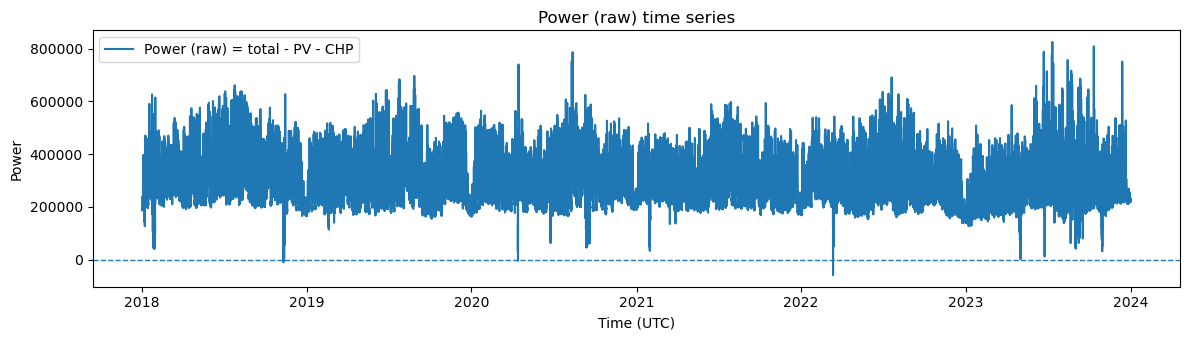

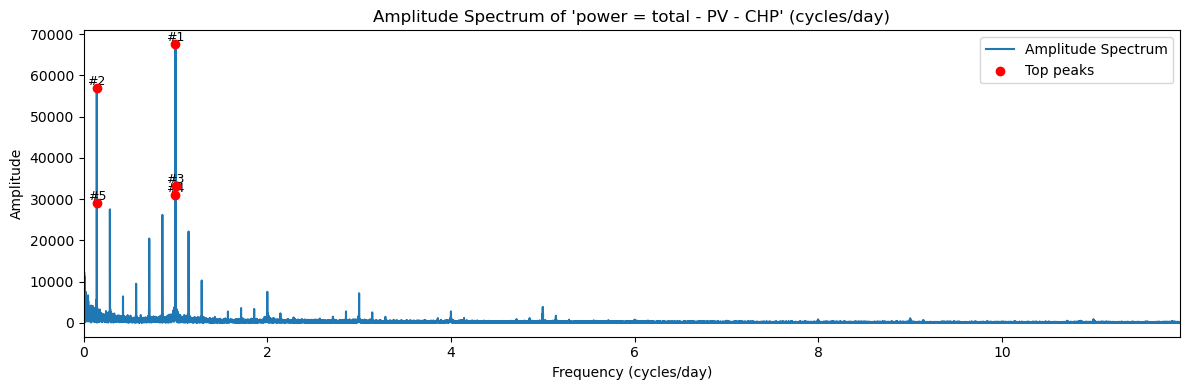

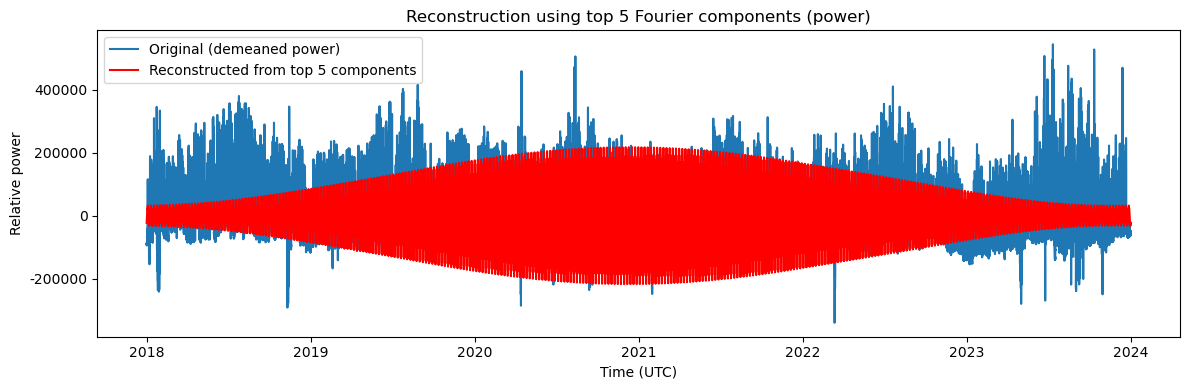

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ==================== SETTINGS ====================
csv_path = Path("electricity_P.csv")   # Input CSV
top_k = 5                               # Top N frequencies to analyze
resample_rule = "1H"                    # Sampling frequency (hourly)
# ==================================================

# 1) Read data
use_cols = ["datetime_utc", "total", "PV", "CHP"]
df = pd.read_csv(csv_path, usecols=use_cols, parse_dates=["datetime_utc"])

# 1.1 Clean & compute power = total - PV - CHP
df = df.set_index("datetime_utc").sort_index()

# Coerce to numeric; treat blanks/invalid as 0
for col in ["total", "PV", "CHP"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

# Compute power per your formula
df["power"] = df["total"] - df["PV"] - df["CHP"]

# 1.2 Resample to hourly mean & interpolate if needed
s = df["power"].resample(resample_rule).mean().interpolate("time")

# Sampling interval (hours)
dt_hours = (s.index[1] - s.index[0]).total_seconds() / 3600.0

# 2) Demean & apply Hann window
x = s.values.astype(float)
x = x - np.nanmean(x)
window = np.hanning(len(x))
xw = x * window

# 3) FFT
X = np.fft.rfft(xw)
window_correction = np.sum(window) / len(window)
X = X / (len(x) * window_correction)

freq_cph = np.fft.rfftfreq(len(x), d=dt_hours)  # cycles per hour
freq_cpd = freq_cph * 24.0                      # cycles per day
amplitude = np.abs(X)
phase = np.angle(X)
if len(amplitude) > 1:
    amplitude[1:-1] *= 2.0  # single-sided amplitude correction (exclude DC & Nyquist)

# 4) Select top_k frequencies (excluding DC) + normalization
mask = freq_cpd > 0
freq_pos = freq_cpd[mask]
amp_pos = amplitude[mask]
phase_pos = phase[mask]

amp_pos_max = np.max(amp_pos) if amp_pos.size > 0 else 0.0
amp_pos_norm = (amp_pos / amp_pos_max) if amp_pos_max > 0 else np.zeros_like(amp_pos)

idx = np.argsort(amp_pos)[::-1][:top_k]
dominant_freqs = freq_pos[idx]
dominant_amps = amp_pos[idx]
dominant_amps_norm = amp_pos_norm[idx]
dominant_phases = phase_pos[idx]
dominant_period_days = 1.0 / dominant_freqs
dominant_period_hours = dominant_period_days * 24.0

# 5) Display main results
print(f"Sampling interval: {dt_hours:.3f} hours/sample")
print(f"Top {top_k} dominant periods (with phase info):")
print("-----------------------------------------------------------")
for i, (f, a, a_norm, phi, pdays, phours) in enumerate(
    zip(dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases,
        dominant_period_days, dominant_period_hours), 1
):
    peak_fraction = (-phi / (2 * np.pi)) % 1.0
    peak_hours = peak_fraction * phours
    print(
        f"{i}. Frequency = {f:.4f} cycles/day, "
        f"Amplitude = {a:,.2f} (norm={a_norm:.4f}), "
        f"Period = {pdays:.3f} days ({phours:.1f} h), "
        f"Phase = {phi:.3f} rad, "
        f"Peak at {peak_fraction*100:.1f}% of cycle (~{peak_hours:.1f} h after start)"
    )

# === (5.1) Machine-readable JSON summary ===
results = {
    "resample_rule": str(resample_rule),
    "top_k": int(top_k),
    "n_samples": int(len(x)),
    "sampling_interval_hours": float(dt_hours),
    "time_start_utc": s.index[0].isoformat(),
    "time_end_utc": s.index[-1].isoformat(),
    "signal": "power = total - PV - CHP",
    "amplitude_normalization": {
        "method": "max_of_positive_frequencies",
        "reference_max_amplitude": float(amp_pos_max),
        "note": "amplitude_normalized = amplitude / max(amplitude over positive frequencies; DC excluded)"
    },
    "dominant_components": []
}

for f, a, a_norm, phi, pdays, phours in zip(
    dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases, dominant_period_days, dominant_period_hours
):
    peak_fraction = float((-phi / (2 * np.pi)) % 1.0)
    peak_hours = float(peak_fraction * phours)

    results["dominant_components"].append({
        "frequency_cycles_per_day": float(f),
        "amplitude": float(a),
        "amplitude_normalized": float(a_norm),
        "phase_rad": float(phi),
        "peak_fraction_of_cycle": peak_fraction,
        "peak_after_hours_from_start": peak_hours,
    })

print("\n=== JSON summary ===")
print(json.dumps(results, ensure_ascii=False, indent=2))

# 6) Plot configuration
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# ---- (A) Time series (demeaned)
plt.figure(figsize=(12, 3.5))
plt.plot(s.index, s.values, label="Power (raw) = total - PV - CHP")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Power (raw) time series")
plt.xlabel("Time (UTC)")
plt.ylabel("Power")
plt.legend()
plt.tight_layout()
plt.show()

# ---- (B) Amplitude spectrum
plt.figure(figsize=(12, 4))
plt.plot(freq_cpd, amplitude, label="Amplitude Spectrum")
plt.scatter(dominant_freqs, dominant_amps, color="red", zorder=5, label="Top peaks")
for i, f in enumerate(dominant_freqs):
    plt.text(f, dominant_amps[i], f"#{i+1}", fontsize=9, ha='center', va='bottom')
plt.xlim(0, np.percentile(freq_cpd, 99.5))
plt.title("Amplitude Spectrum of 'power = total - PV - CHP' (cycles/day)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# ---- (C) Optional: reconstruct dominant components
t = np.arange(len(x)) * dt_hours / 24.0  # time axis in days
reconstructed = np.zeros_like(x)
for f, A, phi in zip(dominant_freqs, dominant_amps, dominant_phases):
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

plt.figure(figsize=(12, 4))
plt.plot(s.index, x, label="Original (demeaned power)")
plt.plot(s.index, reconstructed, label=f"Reconstructed from top {top_k} components", color="red")
plt.title(f"Reconstruction using top {top_k} Fourier components (power)")
plt.xlabel("Time (UTC)")
plt.ylabel("Relative power")
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
negative_times = df[df["power"] < 0].index

if len(negative_times) == 0:
    print("✅ 没有出现 power 为负的时刻。")
else:
    print(f"⚠️ 共有 {len(negative_times)} 个时刻 power < 0。")

    # 3️⃣ 提取这些时间点对应的日期（天）
    negative_days = negative_times.normalize().unique()

    print("\n=== 出现负值的日期列表 ===")
    for d in negative_days:
        print(d.date())

    # 4️⃣ 输出这些天的全部数据
    print("\n=== 这些天的详细数据 ===")
    for d in negative_days:
        day_str = d.strftime("%Y-%m-%d")
        print(f"\n--- {day_str} ---")
        print(df.loc[day_str])

⚠️ 共有 3 个时刻 power < 0。

=== 出现负值的日期列表 ===
2018-11-10
2020-04-13
2022-03-12

=== 这些天的详细数据 ===

--- 2018-11-10 ---
                             total   PV            CHP          power
datetime_utc                                                         
2018-11-10 00:00:00  110738.485958  0.0 -103846.728667  214585.214625
2018-11-10 01:00:00   93254.894437  0.0 -164606.910333  257861.804771
2018-11-10 02:00:00  101649.991534  0.0  -53672.768500  155322.760034
2018-11-10 03:00:00   88789.326485  0.0 -178499.879000  267289.205485
2018-11-10 04:00:00   91553.041377  0.0  -38684.536000  130237.577377
2018-11-10 05:00:00   97836.537270  0.0 -185104.218833  282940.756103
2018-11-10 06:00:00  113066.567964  0.0  -35666.166500  148732.734464
2018-11-10 07:00:00   70540.695274  0.0 -184838.292000  255378.987274
2018-11-10 08:00:00   64242.152632  0.0 -106969.514833  171211.667465
2018-11-10 09:00:00   90104.264694  0.0 -109837.833000  199942.097694
2018-11-10 10:00:00  -33719.011166  0.0  -23054